In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/sign_language.zip -d /content/sign_language_data

Archive:  /content/drive/MyDrive/sign_language.zip
   creating: /content/sign_language_data/sign_language/
   creating: /content/sign_language_data/sign_language/A/
  inflating: /content/sign_language_data/sign_language/A/img (1).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (10).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (11).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (12).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (13).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (14).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (15).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (16).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (17).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (18).jpg  
  inflating: /content/sign_language_data/sign_language/A/img (19).jpg  
  inflating: /content/sign_language_data/sig

In [3]:
from fastai.vision.all import *
from pathlib import Path

path = Path('/content/sign_language_data')

In [67]:
dls = ImageDataLoaders.from_folder(path, valid_pct= 0.2,
                       item_tfms = Resize(448),
                       batch_tfms = aug_transforms(do_flip=False,
                              max_rotate=25,
                              max_zoom=1.2,
                              max_lighting=0.2,
                              max_warp=0.2))

learn = vision_learner(dls, resnet34, metrics=error_rate, pretrained=True)
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,4.225820,2.820847,0.821256,00:30


epoch,train_loss,valid_loss,error_rate,time
0,2.697930,1.387024,0.410628,00:31
1,2.221037,0.583540,0.135266,00:31
2,1.760290,0.288409,0.106280,00:31
3,1.340411,0.124390,0.038647,00:32
4,1.021238,0.076075,0.024155,00:32
5,0.787153,0.047611,0.009662,00:31
6,0.616421,0.024010,0.004831,00:31
7,0.491381,0.019437,0.000000,00:31
8,0.392257,0.025257,0.014493,00:32
9,0.310475,0.025046,0.014493,00:32


SuggestedLRs(valley=0.0002290867705596611)

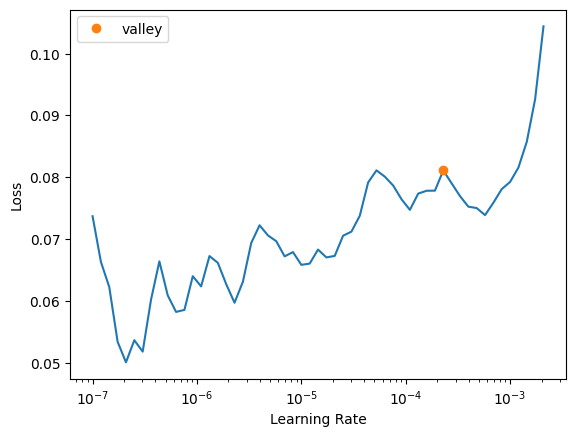

In [69]:
learn.lr_find()


In [70]:
learn.unfreeze()
learn.fit_one_cycle(15, lr_max=slice(2e-6, 2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.072047,0.012545,0.004831,00:31
1,0.067471,0.012037,0.004831,00:32
2,0.064976,0.011184,0.004831,00:33
3,0.061050,0.019128,0.004831,00:31
4,0.061820,0.023590,0.014493,00:31
5,0.051937,0.016150,0.014493,00:31
6,0.050886,0.009419,0.000000,00:33
7,0.052303,0.008316,0.000000,00:31
8,0.053174,0.012721,0.004831,00:32
9,0.049390,0.012788,0.004831,00:31


In [45]:
learn.freeze()
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.112639,0.027448,0.009662,00:30
1,0.110842,0.027401,0.009662,00:30
2,0.107443,0.024164,0.009662,00:30


In [46]:
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=7.6e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.078420,0.019419,0.004831,00:32
1,0.076968,0.027510,0.004831,00:32
2,0.076776,0.070800,0.028986,00:31
3,0.090303,0.026257,0.009662,00:31
4,0.082514,0.015605,0.004831,00:31
5,0.078932,0.023588,0.009662,00:33
6,0.073329,0.014730,0.009662,00:31
7,0.070635,0.008973,0.004831,00:31
8,0.063089,0.006475,0.000000,00:31
9,0.057235,0.005842,0.000000,00:33


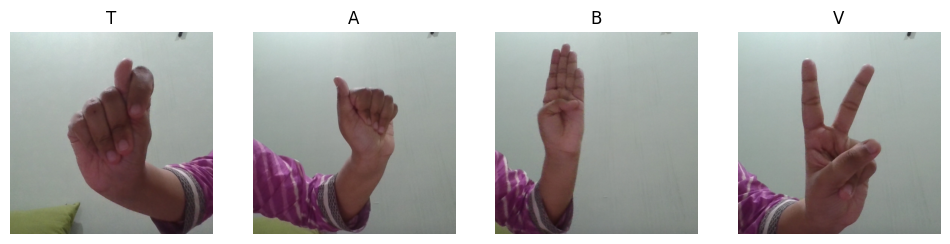

In [47]:
dls.valid.show_batch(max_n = 4, nrows = 1)

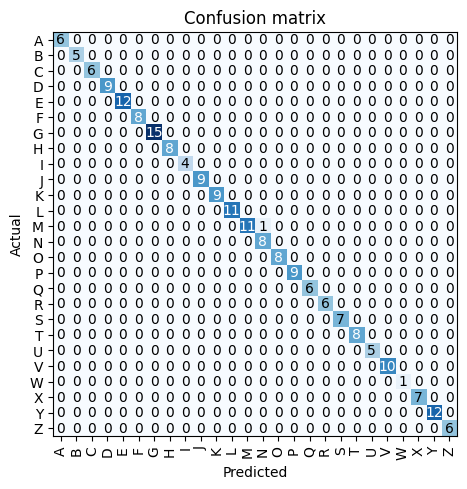

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

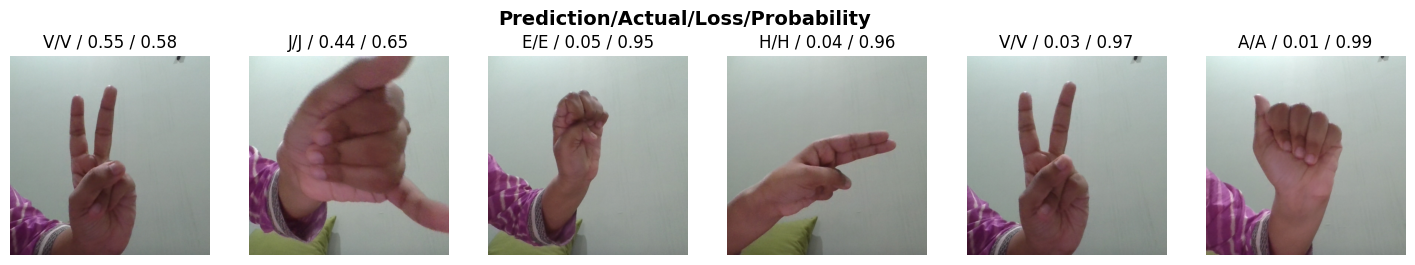

In [50]:
interp.plot_top_losses(6, nrows =1)

In [51]:
from fastai.vision.widgets import *

In [52]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [25]:
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [73]:
learn.export('export2.pkl')

In [74]:
learn_inf = load_learner('/content/sign_language_data/export2.pkl')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [75]:
import ipywidgets as widgets

out_pl = widgets.Output()
label_pred = widgets.Label(value='Prediction will appear here')

In [76]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [80]:
img = PILImage.create(btn_upload.data[-1])
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
pred, pred_idx, probs = learn_inf.predict(img)
label_pred.value = (f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}')
label_pred

Label(value='Prediction: Z; Probability: 0.9103')

In [81]:
import gradio as gr
from fastai.vision.all import *

# Prediction function
def classify_and_append(img, history):
    pred, pred_idx, probs = learn.predict(img)

    # Get top 3 predictions
    top3_idx = probs.argsort(descending=True)[:3]
    top3 = {learn.dls.vocab[i]: float(probs[i]) for i in top3_idx}

    # Append best prediction to history
    best_letter = learn.dls.vocab[pred_idx]
    history = history + best_letter

    return top3, history, history

with gr.Blocks() as demo:
    history = gr.State("")

    with gr.Row():
        img_in = gr.Image(type="pil", label="Upload Sign")
        label_out = gr.Label(label="Top 3 Predictions")

    word_box = gr.Textbox(label="Word so far", interactive=False)

    img_in.upload(
        fn=classify_and_append,
        inputs=[img_in, history],
        outputs=[label_out, word_box, history]
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8e784fcf3c0e85d22a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [72]:
acc = learn.validate()[1]
print(f"Validation Accuracy: {acc:.2%}")


Validation Accuracy: 0.48%
